# Using the simpy_helpers Package

The `simpy_helpers` package was written to make building simulations and collecting statistics about simulations using the Simpy framework simpler. 

`simpy_helpers` provides 4 main classes: 

1. Entity
2. Resource
3. Source
4. Stats


## Entity

An Entity is conceptually the "thing passing through your simulation".   

- An Entity requests resources, performs actions that take time, might reneg and jump out of long queues, etc...
- Each Entity has a set of attributes, stored internally as a dictionary. Examples of attributes might include:
    - Age
    - Food Preference
    - Likelihood to Reneg
    - etc...
- Entities track statistics about their unique journey through the simulation, including waiting time and processing time.

You must define a `process` method for your Entity class



## Resource

A Resource is something an Entity will interact with during a simulation.

- Often resources have a limited `capacity`. 
  - Capacity defines how many entities may be processed by a resource simulatenously before a queue starts to build up.
- Resources may access an entity's attributes to determine the service time for that entity.
- Resources track statistics about their queues size / utilization over time. 

You must define a `service_time` method for your Resource class.



## Source

A Source is used to start a simulation. It is responsible for the following:

- Defining a template for how entities are constructed and fed into a simulation.
- Defining the interarrival time for entities
  - This can be deterministic (e.g. every 5 minutes) or drawn from a distribution (e.g. poisson distribution).

You must define `interarrival_time` and `build_entity` methods for your source class


## Stats

The stats class collects summary statistics about your simulation. You can query it after your simulation completes to check out details of the simulation (e.g. total time per entity through the system, resource utilization over time, waiting time of entities at each resource, etc...)


## Using the simpy_helpers classes

To use the simpy_helpers classes in a simulation, you will need to create `sub-classes` of each the Entity, Resource and Source based on how you've modeled your scenario.

**Note:** It is recommended that you name your sub-classes in terms of the *domain* you are modeling. In the case of the call center:


## Modeling a Call Center Domain

Consider the following scenario:

Say you are the operations manager at a call center. 
- Calls arrive every 1 minute, and you have a team of 2 employees ready to respond to calls. 
- Calls may be for small, medium, or large problems. Calls will fall in to these sizes with the following likelihoods:
  - small: 50%
  - medium: 35%
  - large: 15%
- Small problems take 1 minute, medium problems take 3, and large problems take 10 minutes to address.


How would you use the concepts of Entity, Resource, and Source to model the scenario above? See the following table for where each responsibility lies:

|                                 | Entity     | Resource | Source |
|---------------------------------|------------|----------|--------|
| Call                            | X          |          |        |
| How does call move through sim? | X          |          |        |
| CallCenter                      |            | X        |        |
| 2 Employees                     |            | X        |        |
| Service time for Sm,Md,Lg       |            | X        |        |
| Every 1 minute Call arrives     |            |          | X      |
| Assign Call to Sm,Md,Lg         |            |          | X      |


Here is how we would name the subclasses of each Entity, Resource and Source:

- Entity Classname --> Call
- Resource Classname --> CallCenter
- Source Classname --> CallSource

And here are definitions of each subclass, with all required methods implemented:

In [1]:
import numpy as np
from simpy_helpers import Entity, Resource, Source, Stats
import simpy

## Here is the Entity Subclass
class Call(Entity):
    def process(self):
        yield self.wait_for_resource(call_center)
        yield self.process_at_resource(call_center)
        self.release_resource(call_center)

# Here is the Resource subclass
class CallCenter(Resource):
    def service_time(self, entity):
        problem_size = entity.attributes["problem_size"]
        if problem_size == "sm":
            return 1
        elif problem_size == "md":
            return 3
        else:  # size must be lg at this point
            return 10

# Here is the Source subclass
class CallSource(Source):
    def interarrival_time(self):
        return 1 # every 1 minute, call should arrive to the simulation
    
    def build_entity(self):
        # choose problem_size for this entity based on distribution in scenario.
        problem_size = np.random.choice(["sm", "md", "lg"], p=[0.5, 0.35, 0.15])
        attributes = {
            "problem_size": problem_size
        }
        return Call(env, attributes) # create a call with the chosen problem_size

In [2]:
# Now construct instances of Resource and Source.
np.random.seed(42) # set seed so random parts remain constant between simulations

env = simpy.Environment()
call_center = CallCenter(env, capacity=2) # configure 2 employee capacity
call_source = CallSource(env, number=20) # source will stop after 20 customers have been generated

env.process(call_source.start(debug=True)) # if you want to see printed output for simulation, set debug=True
env.run()

Debug is Enabled
Call 1 created_at: 1 attributes: {'problem_size': 'sm', 'priority': 1, 'disposed': False, 'type': <class '__main__.Call'>}
Call 1 requesting CallCenter: 1
Call 1 started processing at CallCenter : 1
Call 2 created_at: 2 attributes: {'problem_size': 'lg', 'priority': 1, 'disposed': False, 'type': <class '__main__.Call'>}
Call 2 requesting CallCenter: 2
Call 1 finished at CallCenter: 2
Call 2 started processing at CallCenter : 2
Call 1 disposed: 2
Call 3 created_at: 3 attributes: {'problem_size': 'md', 'priority': 1, 'disposed': False, 'type': <class '__main__.Call'>}
Call 3 requesting CallCenter: 3
Call 3 started processing at CallCenter : 3
Call 4 created_at: 4 attributes: {'problem_size': 'md', 'priority': 1, 'disposed': False, 'type': <class '__main__.Call'>}
Call 4 requesting CallCenter: 4
Call 5 created_at: 5 attributes: {'problem_size': 'sm', 'priority': 1, 'disposed': False, 'type': <class '__main__.Call'>}
Call 5 requesting CallCenter: 5
Call 3 finished at CallC

In [3]:
# Now that the simulation has ended, we can use the Stats class to view summary statistics about our simulation

system_time = Stats.get_total_times()
print("total_time:", Stats.get_total_times())
print("total waiting_time:", Stats.get_waiting_times()) 
print("total processing_time:", Stats.get_processing_times(), "\n")

print("waiting time for call_center resource", Stats.get_waiting_times(call_center))
print("processing time for call_center resource", Stats.get_processing_times(call_center))
print("total time at call_center resource", Stats.get_total_times(call_center), "\n")

print("call_center queue size over time", Stats.queue_size_over_time(call_center))
print("call_cetner utilization over time", Stats.utilization_over_time(call_center))

print("entities that were not disposed", Stats.get_total_times(attributes={"disposed": False}))

 
# total_time: [1, 10, 3, 5, 5, 5, 5, 14, 6, 8, 8, 17, 12, 12, 12, 12, 12, 14, 11, 11]
# total waiting_time: [0, 0, 0, 2, 4, 4, 4, 4, 3, 5, 7, 7, 9, 11, 11, 11, 11, 11, 10, 10]
# total processing_time: [1, 10, 3, 3, 1, 1, 1, 10, 3, 3, 1, 10, 3, 1, 1, 1, 1, 3, 1, 1] 

# waiting time for call_center resource [0, 0, 0, 2, 4, 4, 4, 4, 3, 5, 7, 7, 9, 11, 11, 11, 11, 11, 10, 10]
# processing time for call_center resource [1, 10, 3, 3, 1, 1, 1, 10, 3, 3, 1, 10, 3, 1, 1, 1, 1, 3, 1, 1] 

# total time at call_center resource [1, 10, 3, 5, 5, 5, 5, 14, 6, 8, 8, 17, 12, 12, 12, 12, 12, 14, 11, 11] 

# call_center queue size over time [0, 0, 0, 0, 1, 2, 2, 3, 4, 4, 4, 4, 3, 4, 5, 5, 6, 7, 7, 7, 8, 8, 7, 7, 7, 6, 5, 4, 3, 1, 0, 0, 0]
# call_cetner utilization over time [0, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0]

total_time: [1, 10, 3, 5, 5, 5, 5, 14, 6, 8, 8, 17, 12, 12, 12, 12, 12, 14, 11, 11]
total waiting_time: [0, 0, 0, 2, 4, 4, 4, 4, 3, 5, 7, 7, 9, 11, 11, 11, 11, 11, 10, 10]
total processing_time: [1, 10, 3, 3, 1, 1, 1, 10, 3, 3, 1, 10, 3, 1, 1, 1, 1, 3, 1, 1] 

waiting time for call_center resource [0, 0, 0, 2, 4, 4, 4, 4, 3, 5, 7, 7, 9, 11, 11, 11, 11, 11, 10, 10]
processing time for call_center resource [1, 10, 3, 3, 1, 1, 1, 10, 3, 3, 1, 10, 3, 1, 1, 1, 1, 3, 1, 1]
total time at call_center resource [1, 10, 3, 5, 5, 5, 5, 14, 6, 8, 8, 17, 12, 12, 12, 12, 12, 14, 11, 11] 

call_center queue size over time [0, 0, 0, 0, 1, 2, 2, 3, 4, 4, 4, 4, 3, 4, 5, 5, 6, 7, 7, 7, 8, 8, 7, 7, 7, 6, 5, 4, 3, 1, 0, 0, 0]
call_cetner utilization over time [0, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0]
entities that were not disposed []


In [4]:
# we can use the return values from these statistics methods to create charts about our simulation's performance
import matplotlib.pyplot as plt

plt.hist(system_time,bins=5)
# you can customize the exact tick marks on an axis
plt.yticks(range(0,3))
plt.ylabel('Frequency');
plt.xlabel('Time in System');

Average number in queue: 3.757575757575758
Max in queue: 8


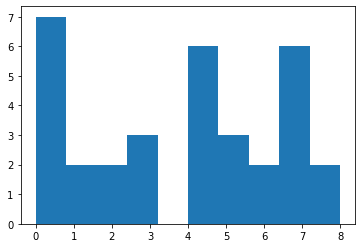

In [5]:
"""
Histogram of queue over time
"""
call_center_queue = Stats.queue_size_over_time(call_center)
plt.hist(call_center_queue)
print(f"Average number in queue: {np.mean(call_center_queue)}")
print(f"Max in queue: {np.max(call_center_queue)}")

# clearly there are some problems with our current setup based on expected customer arrival...

number being processed at call center over time: [0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0]
Average utilization: 0.8939393939393939
Max utilization: 1.0


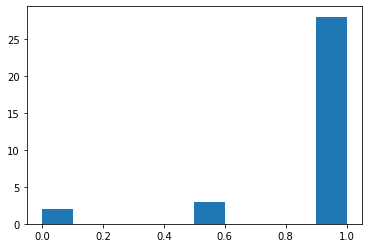

In [7]:
call_center_utilization = Stats.utilization_over_time(call_center)
number_of_calls_being_processed_over_time = Stats.number_being_processed_over_time(call_center)
print(f"number being processed at call center over time: {number_of_calls_being_processed_over_time}")
plt.hist(call_center_utilization)
print(f"Average utilization: {np.mean(call_center_utilization)}")
print(f"Max utilization: {np.max(call_center_utilization)}")

# API Documentation for simpy_helpers Classes

## Entity

#### Methods that You Must Define:

`self.process()` - The steps for how your entity will pass through the simulation
- In the process method you will specify the order in which resources are interacted with by each entity in your system.
- The general pattern for interacting with a resource is to do the following in your process function
  - yield self.request(resource)
  - yield self.start_service_at_resource(resource)
  - self.release_resource(resource)
- you may repeat this pattern for one or more resources.

#### Constructing an Entity: 
`Constructor(env, attributes)` - constructor for entity class
- @param env: a simpy env
- @param attributes (optional): dictionary 

#### Static Variables

`priority`: integer (optional) - the priority assigned to all entities of this type.
- NOTE: priority is honored by resources when determining who to choose next in a queue.
- A lower number priority means the entity will be chosen first. 
- If no priority is specified, entities will have a default priority of 1

#### Predefined Methods: 

`self.wait_for_resource(resource, priority_override)` - adds entity to resource's queue to be processed
- @param resource: a simpy_helpers resource
- @param priority_override (optional): keword arg - an integer to define the prioirty of the requesting entity in the resource queue  
- @yields: a simpy resource request (to be yielded)
  - you must `yield` the results of this method to have your simulation pause correctly.

`self.process_at_resource(resource)` - processes the entity at the resource.
- @param resource: a simpy_helpers resource
- @yields: a simpy env timeout (to be yielded)
  - you must `yield` the results of this method to have your simulation pause correctly 
  - this function calls resource.service_time() method under the hood
  - call this after wait_for_resource

`self.release_resource(resource)` - frees resource to be used by another entity
- @param resource: a simpy_helpers resource
- @returns: void

`self.now()` - returns the current simulation time.
- @returns: Number

`self.wait(duration=0)` - returns a timeout with the specified duration to be yielded
- @returns: timeout to be yielded


#### Entity Stats Methods: 

Note that an entity has its own statistics calculating methods. These are invoked by the `Stats` class under the hood, but you might find yourself wanting to invoke these directly on an entity. 

`self.get_total_time()` - returns the total time that this entity spent in the system (from creation to disposal).
- @returns: Number

`self.get_total_waiting_time()` - returns the total amount of time that the entity waited across *all* resources. 
- @returns: Number

`self.get_waiting_time_for_resource(resource)` - returns the amount of time that the entity waited at the given resource
- @param resource: a simpy_helpers resource
- @returns: Number or None (if entity never visited resource)

`self.get_total_processing_time()` - returns the total amount of time spent processing at all resources during simulation. 
- @returns: Number

`self.get_processing_time_for_resource(resource)` - returns the processing time of the entity at the given resource
- @param resource: a simpy_helpers resource
- @ returns: Number or None (if entity never visited resource)


## Resource

#### Methods That You Must Define:

`self.service_time(entity)` - determine the service time for an entity as it passes through the system
- @param self: instance method 
- @param entity (optional): the entity being serviced
- @returns: number (Int or Float)
  - You may interact with the entity being processed here, to look at attributes and determine the appropriate service time. This is optional though: you may omit the entity parameter from the service_time method definition if service_time is not dependent on entity.

#### Constructing a Resource:

`Constructor(env, capacity=Integer)` - constructor for a resource
- @param env: a simpy env
- @param capacity: keword arg - the capacity of the resource

#### Predefined Methods:

`self.now()` - returns the current simulation time
- @returns: Number


#### Useful Resource Properties

`queue` - A list of simpy requests currently queued at the resource. Take the `len()` of this to determine how many entities are in line for service.
`count` - The number of entities currently being serviced by the resource. `0 <= count <= capacity`

## Container

Sometimes it is useful to manage a consumable resource an see how that value changes over time. The container resource type is useful for this type of modeling. It will track the `level` of the consumable resource over time for you. It can be passed to the stats method for additional querying.

#### Methods that you must define: 

None

#### Constructing a Container

`Constructor(env, max_capacity, init=0)` - constructor for a container
- @param env: a simpy env
- @param max_capacity: Number - the max capacity of your container
- @param init: keyword arg - Number (default 0) - amount of consumable resource to initialize in your container when simulation starts

`self.put(amount)` - the amount to put into the container
- @param amount: number
- @returns: void

`self.get(amount)` - the amount to get from the container
- @param amount: number
- @returns amount: number


## Source

`self.start(debug=False)` - call from env.process to start the simulation
- @param debug (optional) (default=False): keyword arg - a boolean indicating whether to turn verbose printing on during simulation.
- @returns: void

NOTE: setting `debug=True` can be useful while writing a simulation to help understand what is going on, but it will result in a substantial amount of output for large simulations. Consider configuring the source to emit a small number of entities when in debug mode, to ensure output remains limited

`self.get_build_count()` - returns the ID of the current entity being produced from the source. 
- @returns: Integer

`self.now()` - returns the current simulation time
- @returns: Number

#### Methods That You Must Define: 

`self.interarrival_time()` - a function that returns the time at which the next entity will arrive to the simulation
- @returns: number (Int or Float)

`self.build_entity()` - a template for how entities are constructed during simulation
- @returns: simpy_helpers Entity


## Stats

The following methods are available for querying for summary statistics after a simulation has been run. If these methods are called before a simulation has been run, unexpected results may occur.

The stats class is auto-initialized when source.start() is invoked.

These are `Static methods`, meaning they are not invoked off of a class instance, but are invoked from the class itself. i.e `Stats.get_entities()`

`get_entities()` - returns references to all entities that passed through the full simulation (that were disposed).
- @returns: [Entity]

`get_total_times(resource=None, attributes=None)` - returns the total system time for each generated entity 
- @param resource (optional) (default=None): keyword arg - a simpy_helpers resource
- @param attributes (optional) (default=None): keyword arg - a dictionary of attributes to filter entities on
- @returns: [Number]

`get_waiting_times(resource=None, attributes=None)` - returns either the total waiting time or waiting time at a particular resource for each entity.
- @param resource (optional) (default=None): keyword arg - a simpy_helpers resource
- @param attributes (optional) (default=None): keyword arg - a dictionary of attributes to filter entities on
- @returns: [Number]

`get_processing_times(resource=None, attributes=None)` - returns either the total processing time or processing time at a particular resource for each entity.
- @param resource (optional) (default=None): keyword arg - a simpy_helpers resource
- @param attributes (optional) (default=None): keyword arg - a dictionary of attributes to filter entities on
- @returns: [Number]



Note for the `get_*_times` functions

The methods all accept an optional `attributes` parameter which allows you to filter for statistics based on entity attributes. This allows you to examine statistics about subsets of entities in the system.

The resource parameter is optional. If it is provided, it will give you either waiting or processing times at the given resource for each entity that was generated. If it is omitted, you will get total waiting times / processing times across all resources for each entity. When resource is provided, only entities that visited that resource will have times returned (the return array might not be the same length as the nubmer of entities in your system).


`queue_size_over_time(resource, sample_frequency=[0.01, 0.1, 1])` - determine the queue size for a resource over the course of simulation
- @param resource: a simpy_helpers resource
- @param sample_frequency (optional) (default=1): keyword arg - a number in the list [0.01, 0.1, 1]  
- @returns: [Int]

`utilization_over_time(resource, sample_frequency=[0.01, 0.1, 1])` - determine the utilization of a resource over the course of simulation
- @param resource: a simpy_helpers resource
- @param sample_frequency (optional) (default=1): keyword arg - a number in the list [0.01, 0.1, 1] 
- @returns: [Int]

`number_being_processed_over_time(resource, sample_frequency=[0.01, 0.1, 1])` - determine how many entities were being processed by this resource over the course of the simulation
- @param resource: a simpy_helpers resource
- @param sample_frequency (optional) (default=1): keyword arg - a number in the list [0.01, 0.1, 1] 
- @returns: [Int]

`container_level_over_time(container, sample_frequency=[0.01, 0.1, 1])` - determine the level of your container's consumable resource over time.
- @param container: a simpy_helpers container
- @param sample_frequency (optional) (default=1): keyword arg - a number in the list [0.01, 0.1, 1] 
- @returns: [Int]

**NOTE about sample_frequency parameter**: we cannot check the resource queue / utilization / number being processed at every possible time increment: that would be intractable for continuous time simulations. The sample frequency parameter dictates the resolution at which we should sample the history of events that occurred during simulation. The Int array that is returned will have the same resolution as the specified sample frequency (if you specify 0.01 sample frequency, you will get 100 samples per time increment). The default sample frequency is 1, which will work great for discrete time simulations and should work reasonably well for continuous.

## Advanced Topics

### Statistics For Entities That Were Never Disposed

Sometimes you might not have a number restriction on your source, but instead you want to run your simulation `until=` a certain time has elapsed. This is a useful technique for understanding how throughput of your process might change while varying different variables, among others.

In cases such as these, your simulation might end before all entities have completed their `process` function, meaning some entities have not yet been `disposed`. 

The `Stats` class only calculates statistics for entities that have been disposed (out of convenience). It is possible, however, to have `Stats` calculate statistics for non-disposed entities separately. 

The `disposed` status of an entity is automatically tracked as an attribute during simulation. All entity-based Stats methods accept an optional `attributes` dictionary on which to filter entities during statistic gathering.

Knowing this, it is possible to do the following to calculate statistics for non-disposed entities:

`Stats.get_processing_times(attributes={"disposed": False})`
`Stats.get_total_times(attributes={"disposed": False})`
`Stats.get_waiting_times(attributes={"disposed": False})`

Since non-disposed entities could be at varying points during processing (in queue at resource, between resources, processing at a resource, etc...), statistics for disposed entities use a `heuristic` of `simulation_end_time` to essentially cause all processing to terminate early. Hence, the statistics that are calculated for non-disposed entities might be somewhat misleading, and could throw-off any summary statistics about average waiting times, average processing times, etc that you might calculate using Stats values.


